In [20]:
import sys
from string import ascii_uppercase
import itertools
import io
import copy
import time
import matplotlib.ticker as ticker
import random
import pandas as pd
import matplotlib.pyplot as plt
#test_polygon2 = [ (0,1), (1,1), (1,2), (2,2), (2,3), (3,3), (3,2), (4,0), (5,9), (6,0), 
            #  (7,2), (8,0), (8,-2), (7,-3), (6,-2), (5,-2), (4,-2), (3,-1), (2,-2), (1,-2), 
            #  (0,-3), (-2,-3), (-3,-4), (-4,-3), (-5,-3), (-5,-2), (-4,-2), (-4,.5), (-5,.5), (-5,1), 
              #(-4,1), (-4,2), (-4,4), (-3,4), (-3,2), (-2,2), (-2,0), (-1,1), (0,1) ]
#test_polygon2 = [ (0,0),(-8,4),(-4,12),(13,10),(8,2),(-2,4),(6,6), (2,8), (0,0)]
test_polygon2 = [ (2,4),(10,12),(20,4),(8,2),(10,8),(14,6),(2,4)]


In [23]:
b=list()
k=len(test_polygon2)
for i in range(1,k):
    m=(test_polygon2[i%k][1]-test_polygon2[(i-1)%k][1])/(test_polygon2[i%k][0]-test_polygon2[(i-1)%k][0])
    n=(test_polygon2[i%k][1]-m*test_polygon2[i%k][0])
    b.append((m,n))

In [44]:
rectas=pd.DataFrame(b)
rectas.columns=['pendiente','intersepto']
rectas['punto_1']=test_polygon2[0:len(test_polygon2)-1]
rectas['punto_2']=test_polygon2[1:len(test_polygon2)]
rectas

,pendiente,intersepto,punto_1,punto_2
0,1.000000,2.000000,"(2, 4)","(10, 12)"
1,-0.800000,20.000000,"(10, 12)","(20, 4)"
2,0.166667,0.666667,"(20, 4)","(8, 2)"
3,3.000000,-22.000000,"(8, 2)","(10, 8)"
4,-0.500000,13.000000,"(10, 8)","(14, 6)"
5,0.166667,3.666667,"(14, 6)","(2, 4)"


In [92]:
L_X=list()
L_Y=list()
for i in range(len(test_polygon2)-1):
    L_X.append(rectas['punto_1'][i][0])
    L_Y.append(rectas['punto_1'][i][1])
x_limsup=max(L_X)   
x_liminf=min(L_X)
y_limsup=max(L_Y)
y_liminf=min(L_Y)

In [65]:
def isLeft(P0, P1, P2):
    return ((P1[0] - P0[0]) * (P2[1] - P0[1]) - (P2[0] - P0[0]) * (P1[1] - P0[1]))

In [84]:
def wn_PnPoly(P, V):
    n = len(V)-1
    wn= 0    
    i = 0
    while i<n: 
        if V[i][1] <= P[1]:
            
            if V[i+1][1]  > P[1]:   
                if isLeft(V[i], V[i+1], P) > 0: 
                      wn += 1            
        else:                        
              if V[i+1][1] <= P[1]:     
                if isLeft(V[i], V[i+1], P) < 0: 
                      wn -= 1           

        i += 1
  
  #print str(wn)
    return wn;

In [4]:

# BentleyOttmann sweep-line implementation
# (for finding all intersections in a set of line segments)

__all__ = (
    "isect_segments",
    "isect_polygon",

    # same as above but includes segments with each intersections
    "isect_segments_include_segments",
    "isect_polygon_include_segments",

    # for testing only (correct but slow)
    "isect_segments__naive",
    "isect_polygon__naive",
)

# ----------------------------------------------------------------------------
# Main Poly Intersection

# Defines to change behavior.
#
# Whether to ignore intersections of line segments when both
# their end points form the intersection point.
USE_IGNORE_SEGMENT_ENDINGS = True

USE_DEBUG = True

USE_VERBOSE = False

# checks we should NOT need,
# but do them in case we find a test-case that fails.
USE_PARANOID = False

# Support vertical segments,
# (the bentley-ottmann method doesn't support this).
# We use the term 'START_VERTICAL' for a vertical segment,
# to differentiate it from START/END/INTERSECTION
USE_VERTICAL = True
# end defines!
# ------------

# ---------
# Constants
X, Y = 0, 1

# -----------------------------------------------------------------------------
# Switchable Number Implementation

NUMBER_TYPE = 'native'

if NUMBER_TYPE == 'native':
    Real = float
    NUM_EPS = Real("1e-10")
    NUM_INF = Real(float("inf"))
elif NUMBER_TYPE == 'decimal':
    # Not passing tests!
    import decimal
    Real = decimal.Decimal
    decimal.getcontext().prec = 80
    NUM_EPS = Real("1e-10")
    NUM_INF = Real(float("inf"))
elif NUMBER_TYPE == 'numpy':
    import numpy
    Real = numpy.float64
    del numpy
    NUM_EPS = Real("1e-10")
    NUM_INF = Real(float("inf"))
elif NUMBER_TYPE == 'gmpy2':
    # Not passing tests!
    import gmpy2
    gmpy2.set_context(gmpy2.ieee(128))
    Real = gmpy2.mpz
    NUM_EPS = Real(float("1e-10"))
    NUM_INF = gmpy2.get_emax_max()
    del gmpy2
else:
    raise Exception("Type not found")

NUM_EPS_SQ = NUM_EPS * NUM_EPS
NUM_ZERO = Real(0.0)
NUM_ONE = Real(1.0)


class Event:
    __slots__ = (
        "type",
        "point",
        "segment",

        # this is just cache,
        # we may remove or calculate slope on the fly
        "slope",
        "span",
    ) + (() if not USE_DEBUG else (
        # debugging only
        "other",
        "in_sweep",
    ))

    class Type:
        END = 0
        INTERSECTION = 1
        START = 2
        if USE_VERTICAL:
            START_VERTICAL = 3

    def __init__(self, type, point, segment, slope):
        assert(isinstance(point, tuple))
        self.type = type
        self.point = point
        self.segment = segment

        # will be None for INTERSECTION
        self.slope = slope
        if segment is not None:
            self.span = segment[1][X] - segment[0][X]

        if USE_DEBUG:
            self.other = None
            self.in_sweep = False

    # note that this isn't essential,
    # it just avoids non-deterministic ordering, see #9.
    def __hash__(self):
        return hash(self.point)

    def is_vertical(self):
        # return self.segment[0][X] == self.segment[1][X]
        return self.span == NUM_ZERO

    def y_intercept_x(self, x: Real):
        # vertical events only for comparison (above_all check)
        # never added into the binary-tree its self
        if USE_VERTICAL:
            if self.is_vertical():
                return None

        if x <= self.segment[0][X]:
            return self.segment[0][Y]
        elif x >= self.segment[1][X]:
            return self.segment[1][Y]

        # use the largest to avoid float precision error with nearly vertical lines.
        delta_x0 = x - self.segment[0][X]
        delta_x1 = self.segment[1][X] - x
        if delta_x0 > delta_x1:
            ifac = delta_x0 / self.span
            fac = NUM_ONE - ifac
        else:
            fac = delta_x1 / self.span
            ifac = NUM_ONE - fac
        assert(fac <= NUM_ONE)
        return (self.segment[0][Y] * fac) + (self.segment[1][Y] * ifac)

    @staticmethod
    def Compare(sweep_line, this, that):
        if this is that:
            return 0
        if USE_DEBUG:
            if this.other is that:
                return 0
        current_point_x = sweep_line._current_event_point_x
        this_y = this.y_intercept_x(current_point_x)
        that_y = that.y_intercept_x(current_point_x)
        # print(this_y, that_y)
        if USE_VERTICAL:
            if this_y is None:
                this_y = this.point[Y]
            if that_y is None:
                that_y = that.point[Y]

        delta_y = this_y - that_y

        assert((delta_y < NUM_ZERO) == (this_y < that_y))
        # NOTE, VERY IMPORTANT TO USE EPSILON HERE!
        # otherwise w/ float precision errors we get incorrect comparisons
        # can get very strange & hard to debug output without this.
        if abs(delta_y) > NUM_EPS:
            return -1 if (delta_y < NUM_ZERO) else 1
        else:
            this_slope = this.slope
            that_slope = that.slope
            if this_slope != that_slope:
                if sweep_line._before:
                    return -1 if (this_slope > that_slope) else 1
                else:
                    return 1 if (this_slope > that_slope) else -1

        delta_x_p1 = this.segment[0][X] - that.segment[0][X]
        if delta_x_p1 != NUM_ZERO:
            return -1 if (delta_x_p1 < NUM_ZERO) else 1

        delta_x_p2 = this.segment[1][X] - that.segment[1][X]
        if delta_x_p2 != NUM_ZERO:
            return -1 if (delta_x_p2 < NUM_ZERO) else 1

        return 0

    def __repr__(self):
        return ("Event(0x%x, s0=%r, s1=%r, p=%r, type=%d, slope=%r)" % (
            id(self),
            self.segment[0], self.segment[1],
            self.point,
            self.type,
            self.slope,
        ))


class SweepLine:
    __slots__ = (
        # A map holding all intersection points mapped to the Events
        # that form these intersections.
        # {Point: set(Event, ...), ...}
        "intersections",
        "queue",

        # Events (sorted set of ordered events, no values)
        #
        # note: START & END events are considered the same so checking if an event is in the tree
        # will return true if its opposite side is found.
        # This is essential for the algorithm to work, and why we don't explicitly remove START events.
        # Instead, the END events are never added to the current sweep, and removing them also removes the start.
        "_events_current_sweep",
        # The point of the current Event.
        "_current_event_point_x",
        # A flag to indicate if we're slightly before or after the line.
        "_before",
    )

    def __init__(self):
        self.intersections = {}

        self._current_event_point_x = None
        self._events_current_sweep = RBTree(cmp=Event.Compare, cmp_data=self)
        self._before = True

    def get_intersections(self):
        """
        Return a list of unordered intersection points.
        """
        if Real is float:
            return list(self.intersections.keys())
        else:
            return [(float(p[0]), float(p[1])) for p in self.intersections.keys()]

    # Not essential for implementing this algorithm, but useful.
    def get_intersections_with_segments(self):
        """
        Return a list of unordered intersection '(point, segment)' pairs,
        where segments may contain 2 or more values.
        """
        if Real is float:
            return [
                (p, [event.segment for event in event_set])
                for p, event_set in self.intersections.items()
            ]
        else:
            return [
                (
                    (float(p[0]), float(p[1])),
                    [((float(event.segment[0][0]), float(event.segment[0][1])),
                      (float(event.segment[1][0]), float(event.segment[1][1])))
                     for event in event_set],
                )
                for p, event_set in self.intersections.items()
            ]

    # Checks if an intersection exists between two Events 'a' and 'b'.
    def _check_intersection(self, a: Event, b: Event):
        # Return immediately in case either of the events is null, or
        # if one of them is an INTERSECTION event.
        if (
                (a is None or b is None) or
                (a.type == Event.Type.INTERSECTION) or
                (b.type == Event.Type.INTERSECTION)
        ):
            return

        if a is b:
            return

        # Get the intersection point between 'a' and 'b'.
        p = isect_seg_seg_v2_point(
            a.segment[0], a.segment[1],
            b.segment[0], b.segment[1],
        )

        # No intersection exists.
        if p is None:
            return

        # If the intersection is formed by both the segment endings, AND
        # USE_IGNORE_SEGMENT_ENDINGS is true,
        # return from this method.
        if USE_IGNORE_SEGMENT_ENDINGS:
            if ((len_squared_v2v2(p, a.segment[0]) < NUM_EPS_SQ or
                 len_squared_v2v2(p, a.segment[1]) < NUM_EPS_SQ) and
                (len_squared_v2v2(p, b.segment[0]) < NUM_EPS_SQ or
                 len_squared_v2v2(p, b.segment[1]) < NUM_EPS_SQ)):

                return

        # Add the intersection.
        events_for_point = self.intersections.pop(p, set())
        is_new = len(events_for_point) == 0
        events_for_point.add(a)
        events_for_point.add(b)
        self.intersections[p] = events_for_point

        # If the intersection occurs to the right of the sweep line, OR
        # if the intersection is on the sweep line and it's above the
        # current event-point, add it as a new Event to the queue.
        if is_new and p[X] >= self._current_event_point_x:
            event_isect = Event(Event.Type.INTERSECTION, p, None, None)
            self.queue.offer(p, event_isect)

    def _sweep_to(self, p):
        if p[X] == self._current_event_point_x:
            # happens in rare cases,
            # we can safely ignore
            return

        self._current_event_point_x = p[X]

    def insert(self, event):
        assert(event not in self._events_current_sweep)
        assert(not USE_VERTICAL or event.type != Event.Type.START_VERTICAL)
        if USE_DEBUG:
            assert(event.in_sweep == False)
            assert(event.other.in_sweep == False)

        self._events_current_sweep.insert(event, None)

        if USE_DEBUG:
            event.in_sweep = True
            event.other.in_sweep = True

    def remove(self, event):
        try:
            self._events_current_sweep.remove(event)
            if USE_DEBUG:
                assert(event.in_sweep == True)
                assert(event.other.in_sweep == True)
                event.in_sweep = False
                event.other.in_sweep = False
            return True
        except KeyError:
            if USE_DEBUG:
                assert(event.in_sweep == False)
                assert(event.other.in_sweep == False)
            return False

    def above(self, event):
        return self._events_current_sweep.succ_key(event, None)

    def below(self, event):
        return self._events_current_sweep.prev_key(event, None)

    '''
    def above_all(self, event):
        while True:
            event = self.above(event)
            if event is None:
                break
            yield event
    '''

    def above_all(self, event):
        # assert(event not in self._events_current_sweep)
        return self._events_current_sweep.key_slice(event, None, reverse=False)

    def handle(self, p, events_current):
        if len(events_current) == 0:
            return
        # done already
        # self._sweep_to(events_current[0])
        assert(p[0] == self._current_event_point_x)

        if not USE_IGNORE_SEGMENT_ENDINGS:
            if len(events_current) > 1:
                for i in range(0, len(events_current) - 1):
                    for j in range(i + 1, len(events_current)):
                        self._check_intersection(
                            events_current[i], events_current[j])

        for e in events_current:
            self.handle_event(e)

    def handle_event(self, event):
        t = event.type
        if t == Event.Type.START:
            # print("  START")
            self._before = False
            self.insert(event)

            e_above = self.above(event)
            e_below = self.below(event)

            self._check_intersection(event, e_above)
            self._check_intersection(event, e_below)
            if USE_PARANOID:
                self._check_intersection(e_above, e_below)

        elif t == Event.Type.END:
            # print("  END")
            self._before = True

            e_above = self.above(event)
            e_below = self.below(event)

            self.remove(event)

            self._check_intersection(e_above, e_below)
            if USE_PARANOID:
                self._check_intersection(event, e_above)
                self._check_intersection(event, e_below)

        elif t == Event.Type.INTERSECTION:
            # print("  INTERSECTION")
            self._before = True
            event_set = self.intersections[event.point]
            # note: events_current aren't sorted.
            reinsert_stack = []  # Stack
            for e in event_set:
                # Since we know the Event wasn't already removed,
                # we want to insert it later on.
                if self.remove(e):
                    reinsert_stack.append(e)
            self._before = False

            # Insert all Events that we were able to remove.
            while reinsert_stack:
                e = reinsert_stack.pop()

                self.insert(e)

                e_above = self.above(e)
                e_below = self.below(e)

                self._check_intersection(e, e_above)
                self._check_intersection(e, e_below)
                if USE_PARANOID:
                    self._check_intersection(e_above, e_below)
        elif (USE_VERTICAL and
              (t == Event.Type.START_VERTICAL)):

            # just check sanity
            assert(event.segment[0][X] == event.segment[1][X])
            assert(event.segment[0][Y] <= event.segment[1][Y])

            # In this case we only need to find all segments in this span.
            y_above_max = event.segment[1][Y]

            # self.insert(event)
            for e_above in self.above_all(event):
                if e_above.type == Event.Type.START_VERTICAL:
                    continue
                y_above = e_above.y_intercept_x(
                    self._current_event_point_x)
                if USE_IGNORE_SEGMENT_ENDINGS:
                    if y_above >= y_above_max - NUM_EPS:
                        break
                else:
                    if y_above > y_above_max:
                        break

                # We know this intersects,
                # so we could use a faster function now:
                # ix = (self._current_event_point_x, y_above)
                # ...however best use existing functions
                # since it does all sanity checks on endpoints... etc.
                self._check_intersection(event, e_above)

            # self.remove(event)


class EventQueue:
    __slots__ = (
        # note: we only ever pop_min, this could use a 'heap' structure.
        # The sorted map holding the points -> event list
        # [Point: Event] (tree)
        "events_scan",
    )

    def __init__(self, segments, line: SweepLine):
        self.events_scan = RBTree()
        # segments = [s for s in segments if s[0][0] != s[1][0] and s[0][1] != s[1][1]]

        for s in segments:
            assert(s[0][X] <= s[1][X])

            slope = slope_v2v2(*s)

            if s[0] == s[1]:
                pass
            elif USE_VERTICAL and (s[0][X] == s[1][X]):
                e_start = Event(Event.Type.START_VERTICAL, s[0], s, slope)

                if USE_DEBUG:
                    e_start.other = e_start  # FAKE, avoid error checking

                self.offer(s[0], e_start)
            else:
                e_start = Event(Event.Type.START, s[0], s, slope)
                e_end   = Event(Event.Type.END,   s[1], s, slope)

                if USE_DEBUG:
                    e_start.other = e_end
                    e_end.other = e_start

                self.offer(s[0], e_start)
                self.offer(s[1], e_end)

        line.queue = self

    def offer(self, p, e: Event):
        """
        Offer a new event ``s`` at point ``p`` in this queue.
        """
        existing = self.events_scan.setdefault(
            p, ([], [], [], []) if USE_VERTICAL else
            ([], [], []),
        )
        # Can use double linked-list for easy insertion at beginning/end
        '''
        if e.type == Event.Type.END:
            existing.insert(0, e)
        else:
            existing.append(e)
        '''

        existing[e.type].append(e)

    # return a set of events
    def poll(self):
        """
        Get, and remove, the first (lowest) item from this queue.
        :return: the first (lowest) item from this queue.
        :rtype: Point, Event pair.
        """
        assert(len(self.events_scan) != 0)
        p, events_current = self.events_scan.pop_min()
        return p, events_current


def isect_segments_impl(segments, include_segments=False) -> list:
    # order points left -> right
    if Real is float:
        segments = [
            # in nearly all cases, comparing X is enough,
            # but compare Y too for vertical lines
            (s[0], s[1]) if (s[0] <= s[1]) else
            (s[1], s[0])
            for s in segments]
    else:
        segments = [
            # in nearly all cases, comparing X is enough,
            # but compare Y too for vertical lines
            (
                (Real(s[0][0]), Real(s[0][1])),
                (Real(s[1][0]), Real(s[1][1])),
            ) if (s[0] <= s[1]) else
            (
                (Real(s[1][0]), Real(s[1][1])),
                (Real(s[0][0]), Real(s[0][1])),
            )
            for s in segments]

    sweep_line = SweepLine()
    queue = EventQueue(segments, sweep_line)

    while len(queue.events_scan) > 0:
        if USE_VERBOSE:
            print(len(queue.events_scan), sweep_line._current_event_point_x)
        p, e_ls = queue.poll()
        for events_current in e_ls:
            if events_current:
                sweep_line._sweep_to(p)
                sweep_line.handle(p, events_current)

    if include_segments is False:
        return sweep_line.get_intersections()
    else:
        return sweep_line.get_intersections_with_segments()


def isect_polygon_impl(points, include_segments=False) -> list:
    n = len(points)
    segments = [
        (tuple(points[i]), tuple(points[(i + 1) % n]))
        for i in range(n)]
    return isect_segments_impl(segments, include_segments=include_segments)


def isect_segments(segments) -> list:
    return isect_segments_impl(segments, include_segments=False)


def isect_polygon(segments) -> list:
    return isect_polygon_impl(segments, include_segments=False)


def isect_segments_include_segments(segments) -> list:
    return isect_segments_impl(segments, include_segments=True)


def isect_polygon_include_segments(segments) -> list:
    return isect_polygon_impl(segments, include_segments=True)


# ----------------------------------------------------------------------------
# 2D math utilities


def slope_v2v2(p1, p2):
    if p1[X] == p2[X]:
        if p1[Y] < p2[Y]:
            return NUM_INF
        else:
            return -NUM_INF
    else:
        return (p2[Y] - p1[Y]) / (p2[X] - p1[X])


def sub_v2v2(a, b):
    return (
        a[0] - b[0],
        a[1] - b[1])


def dot_v2v2(a, b):
    return (
        (a[0] * b[0]) +
        (a[1] * b[1]))


def len_squared_v2v2(a, b):
    c = sub_v2v2(a, b)
    return dot_v2v2(c, c)


def line_point_factor_v2(p, l1, l2, default=NUM_ZERO):
    u = sub_v2v2(l2, l1)
    h = sub_v2v2(p, l1)
    dot = dot_v2v2(u, u)
    return (dot_v2v2(u, h) / dot) if dot != NUM_ZERO else default


def isect_seg_seg_v2_point(v1, v2, v3, v4, bias=NUM_ZERO):
    # Only for predictability and hashable point when same input is given
    if v1 > v2:
        v1, v2 = v2, v1
    if v3 > v4:
        v3, v4 = v4, v3

    if (v1, v2) > (v3, v4):
        v1, v2, v3, v4 = v3, v4, v1, v2

    div = (v2[0] - v1[0]) * (v4[1] - v3[1]) - (v2[1] - v1[1]) * (v4[0] - v3[0])
    if div == NUM_ZERO:
        return None

    vi = (((v3[0] - v4[0]) *
           (v1[0] * v2[1] - v1[1] * v2[0]) - (v1[0] - v2[0]) *
           (v3[0] * v4[1] - v3[1] * v4[0])) / div,
          ((v3[1] - v4[1]) *
           (v1[0] * v2[1] - v1[1] * v2[0]) - (v1[1] - v2[1]) *
           (v3[0] * v4[1] - v3[1] * v4[0])) / div,
          )

    fac = line_point_factor_v2(vi, v1, v2, default=-NUM_ONE)
    if fac < NUM_ZERO - bias or fac > NUM_ONE + bias:
        return None

    fac = line_point_factor_v2(vi, v3, v4, default=-NUM_ONE)
    if fac < NUM_ZERO - bias or fac > NUM_ONE + bias:
        return None

    # vi = round(vi[X], 8), round(vi[Y], 8)
    return vi


# ----------------------------------------------------------------------------
# Simple naive line intersect, (for testing only)


def isect_segments__naive(segments) -> list:
    """
    Brute force O(n2) version of ``isect_segments`` for test validation.
    """
    isect = []

    # order points left -> right
    if Real is float:
        segments = [
            (s[0], s[1]) if s[0][X] <= s[1][X] else
            (s[1], s[0])
            for s in segments]
    else:
        segments = [
            (
                (Real(s[0][0]), Real(s[0][1])),
                (Real(s[1][0]), Real(s[1][1])),
            ) if (s[0] <= s[1]) else
            (
                (Real(s[1][0]), Real(s[1][1])),
                (Real(s[0][0]), Real(s[0][1])),
            )
            for s in segments]

    n = len(segments)

    for i in range(n):
        a0, a1 = segments[i]
        for j in range(i + 1, n):
            b0, b1 = segments[j]
            if a0 not in (b0, b1) and a1 not in (b0, b1):
                ix = isect_seg_seg_v2_point(a0, a1, b0, b1)
                if ix is not None:
                    # USE_IGNORE_SEGMENT_ENDINGS handled already
                    isect.append(ix)

    return isect


def isect_polygon__naive(points) -> list:
    """
    Brute force O(n2) version of ``isect_polygon`` for test validation.
    """
    isect = []

    n = len(points)

    if Real is float:
        pass
    else:
        points = [(Real(p[0]), Real(p[1])) for p in points]


    for i in range(n):
        a0, a1 = points[i], points[(i + 1) % n]
        for j in range(i + 1, n):
            b0, b1 = points[j], points[(j + 1) % n]
            if a0 not in (b0, b1) and a1 not in (b0, b1):
                ix = isect_seg_seg_v2_point(a0, a1, b0, b1)
                if ix is not None:

                    if USE_IGNORE_SEGMENT_ENDINGS:
                        if ((len_squared_v2v2(ix, a0) < NUM_EPS_SQ or
                             len_squared_v2v2(ix, a1) < NUM_EPS_SQ) and
                            (len_squared_v2v2(ix, b0) < NUM_EPS_SQ or
                             len_squared_v2v2(ix, b1) < NUM_EPS_SQ)):
                            continue

                    isect.append(ix)

    return isect


# ----------------------------------------------------------------------------
# Inline Libs
#
# bintrees: 2.0.2, extracted from:
# http://pypi.python.org/pypi/bintrees
#
# - Removed unused functions, such as slicing and range iteration.
# - Added 'cmp' and and 'cmp_data' arguments,
#   so we can define our own comparison that takes an arg.
#   Needed for sweep-line.
# - Added support for 'default' arguments for prev_item/succ_item,
#   so we can avoid exception handling.

# -------
# ABCTree

from operator import attrgetter
_sentinel = object()


class _ABCTree(object):
    def __init__(self, cmp=None, cmp_data=None):
        """T.__init__(...) initializes T; see T.__class__.__doc__ for signature"""
        self._root = None
        self._count = 0
        if cmp is None:
            def cmp(cmp_data, a, b):
                if a < b:
                    return -1
                elif a > b:
                    return 1
                else:
                    return 0
        self._cmp = cmp
        self._cmp_data = cmp_data

    def clear(self):
        """T.clear() -> None.  Remove all items from T."""
        def _clear(node):
            if node is not None:
                _clear(node.left)
                _clear(node.right)
                node.free()
        _clear(self._root)
        self._count = 0
        self._root = None

    @property
    def count(self):
        """Get items count."""
        return self._count

    def get_value(self, key):
        node = self._root
        while node is not None:
            cmp = self._cmp(self._cmp_data, key, node.key)
            if cmp == 0:
                return node.value
            elif cmp < 0:
                node = node.left
            else:
                node = node.right
        raise KeyError(str(key))

    def pop_item(self):
        """T.pop_item() -> (k, v), remove and return some (key, value) pair as a
        2-tuple; but raise KeyError if T is empty.
        """
        if self.is_empty():
            raise KeyError("pop_item(): tree is empty")
        node = self._root
        while True:
            if node.left is not None:
                node = node.left
            elif node.right is not None:
                node = node.right
            else:
                break
        key = node.key
        value = node.value
        self.remove(key)
        return key, value
    popitem = pop_item  # for compatibility  to dict()

    def min_item(self):
        """Get item with min key of tree, raises ValueError if tree is empty."""
        if self.is_empty():
            raise ValueError("Tree is empty")
        node = self._root
        while node.left is not None:
            node = node.left
        return node.key, node.value

    def max_item(self):
        """Get item with max key of tree, raises ValueError if tree is empty."""
        if self.is_empty():
            raise ValueError("Tree is empty")
        node = self._root
        while node.right is not None:
            node = node.right
        return node.key, node.value

    def succ_item(self, key, default=_sentinel):
        """Get successor (k,v) pair of key, raises KeyError if key is max key
        or key does not exist. optimized for pypy.
        """
        # removed graingets version, because it was little slower on CPython and much slower on pypy
        # this version runs about 4x faster with pypy than the Cython version
        # Note: Code sharing of succ_item() and ceiling_item() is possible, but has always a speed penalty.
        node = self._root
        succ_node = None
        while node is not None:
            cmp = self._cmp(self._cmp_data, key, node.key)
            if cmp == 0:
                break
            elif cmp < 0:
                if (succ_node is None) or self._cmp(self._cmp_data, node.key, succ_node.key) < 0:
                    succ_node = node
                node = node.left
            else:
                node = node.right

        if node is None:  # stay at dead end
            if default is _sentinel:
                raise KeyError(str(key))
            return default
        # found node of key
        if node.right is not None:
            # find smallest node of right subtree
            node = node.right
            while node.left is not None:
                node = node.left
            if succ_node is None:
                succ_node = node
            elif self._cmp(self._cmp_data, node.key, succ_node.key) < 0:
                succ_node = node
        elif succ_node is None:  # given key is biggest in tree
            if default is _sentinel:
                raise KeyError(str(key))
            return default
        return succ_node.key, succ_node.value

    def prev_item(self, key, default=_sentinel):
        """Get predecessor (k,v) pair of key, raises KeyError if key is min key
        or key does not exist. optimized for pypy.
        """
        # removed graingets version, because it was little slower on CPython and much slower on pypy
        # this version runs about 4x faster with pypy than the Cython version
        # Note: Code sharing of prev_item() and floor_item() is possible, but has always a speed penalty.
        node = self._root
        prev_node = None

        while node is not None:
            cmp = self._cmp(self._cmp_data, key, node.key)
            if cmp == 0:
                break
            elif cmp < 0:
                node = node.left
            else:
                if (prev_node is None) or self._cmp(self._cmp_data, prev_node.key, node.key) < 0:
                    prev_node = node
                node = node.right

        if node is None:  # stay at dead end (None)
            if default is _sentinel:
                raise KeyError(str(key))
            return default
        # found node of key
        if node.left is not None:
            # find biggest node of left subtree
            node = node.left
            while node.right is not None:
                node = node.right
            if prev_node is None:
                prev_node = node
            elif self._cmp(self._cmp_data, prev_node.key, node.key) < 0:
                prev_node = node
        elif prev_node is None:  # given key is smallest in tree
            if default is _sentinel:
                raise KeyError(str(key))
            return default
        return prev_node.key, prev_node.value

    def __repr__(self):
        """T.__repr__(...) <==> repr(x)"""
        tpl = "%s({%s})" % (self.__class__.__name__, '%s')
        return tpl % ", ".join(("%r: %r" % item for item in self.items()))

    def __contains__(self, key):
        """k in T -> True if T has a key k, else False"""
        try:
            self.get_value(key)
            return True
        except KeyError:
            return False

    def __len__(self):
        """T.__len__() <==> len(x)"""
        return self.count

    def is_empty(self):
        """T.is_empty() -> False if T contains any items else True"""
        return self.count == 0

    def set_default(self, key, default=None):
        """T.set_default(k[,d]) -> T.get(k,d), also set T[k]=d if k not in T"""
        try:
            return self.get_value(key)
        except KeyError:
            self.insert(key, default)
            return default
    setdefault = set_default  # for compatibility to dict()

    def get(self, key, default=None):
        """T.get(k[,d]) -> T[k] if k in T, else d.  d defaults to None."""
        try:
            return self.get_value(key)
        except KeyError:
            return default

    def pop(self, key, *args):
        """T.pop(k[,d]) -> v, remove specified key and return the corresponding value.
        If key is not found, d is returned if given, otherwise KeyError is raised
        """
        if len(args) > 1:
            raise TypeError("pop expected at most 2 arguments, got %d" % (1 + len(args)))
        try:
            value = self.get_value(key)
            self.remove(key)
            return value
        except KeyError:
            if len(args) == 0:
                raise
            else:
                return args[0]

    def prev_key(self, key, default=_sentinel):
        """Get predecessor to key, raises KeyError if key is min key
        or key does not exist.
        """
        item = self.prev_item(key, default)
        return default if item is default else item[0]

    def succ_key(self, key, default=_sentinel):
        """Get successor to key, raises KeyError if key is max key
        or key does not exist.
        """
        item = self.succ_item(key, default)
        return default if item is default else item[0]

    def pop_min(self):
        """T.pop_min() -> (k, v), remove item with minimum key, raise ValueError
        if T is empty.
        """
        item = self.min_item()
        self.remove(item[0])
        return item

    def pop_max(self):
        """T.pop_max() -> (k, v), remove item with maximum key, raise ValueError
        if T is empty.
        """
        item = self.max_item()
        self.remove(item[0])
        return item

    def min_key(self):
        """Get min key of tree, raises ValueError if tree is empty. """
        return self.min_item()[0]

    def max_key(self):
        """Get max key of tree, raises ValueError if tree is empty. """
        return self.max_item()[0]

    def key_slice(self, start_key, end_key, reverse=False):
        """T.key_slice(start_key, end_key) -> key iterator:
        start_key <= key < end_key.
        Yields keys in ascending order if reverse is False else in descending order.
        """
        return (k for k, v in self.iter_items(start_key, end_key, reverse=reverse))

    def iter_items(self,  start_key=None, end_key=None, reverse=False):
        """Iterates over the (key, value) items of the associated tree,
        in ascending order if reverse is True, iterate in descending order,
        reverse defaults to False"""
        # optimized iterator (reduced method calls) - faster on CPython but slower on pypy

        if self.is_empty():
            return []
        if reverse:
            return self._iter_items_backward(start_key, end_key)
        else:
            return self._iter_items_forward(start_key, end_key)

    def _iter_items_forward(self, start_key=None, end_key=None):
        for item in self._iter_items(left=attrgetter("left"), right=attrgetter("right"),
                                     start_key=start_key, end_key=end_key):
            yield item

    def _iter_items_backward(self, start_key=None, end_key=None):
        for item in self._iter_items(left=attrgetter("right"), right=attrgetter("left"),
                                     start_key=start_key, end_key=end_key):
            yield item

    def _iter_items(self, left=attrgetter("left"), right=attrgetter("right"), start_key=None, end_key=None):
        node = self._root
        stack = []
        go_left = True
        in_range = self._get_in_range_func(start_key, end_key)

        while True:
            if left(node) is not None and go_left:
                stack.append(node)
                node = left(node)
            else:
                if in_range(node.key):
                    yield node.key, node.value
                if right(node) is not None:
                    node = right(node)
                    go_left = True
                else:
                    if not len(stack):
                        return  # all done
                    node = stack.pop()
                    go_left = False

    def _get_in_range_func(self, start_key, end_key):
        if start_key is None and end_key is None:
            return lambda x: True
        else:
            if start_key is None:
                start_key = self.min_key()
            if end_key is None:
                return (lambda x: self._cmp(self._cmp_data, start_key, x) <= 0)
            else:
                return (lambda x: self._cmp(self._cmp_data, start_key, x) <= 0 and
                        self._cmp(self._cmp_data, x, end_key) < 0)


# ------
# RBTree

class Node(object):
    """Internal object, represents a tree node."""
    __slots__ = ['key', 'value', 'red', 'left', 'right']

    def __init__(self, key=None, value=None):
        self.key = key
        self.value = value
        self.red = True
        self.left = None
        self.right = None

    def free(self):
        self.left = None
        self.right = None
        self.key = None
        self.value = None

    def __getitem__(self, key):
        """N.__getitem__(key) <==> x[key], where key is 0 (left) or 1 (right)."""
        return self.left if key == 0 else self.right

    def __setitem__(self, key, value):
        """N.__setitem__(key, value) <==> x[key]=value, where key is 0 (left) or 1 (right)."""
        if key == 0:
            self.left = value
        else:
            self.right = value


class RBTree(_ABCTree):
    """
    RBTree implements a balanced binary tree with a dict-like interface.
    see: http://en.wikipedia.org/wiki/Red_black_tree
    """
    @staticmethod
    def is_red(node):
        if (node is not None) and node.red:
            return True
        else:
            return False

    @staticmethod
    def jsw_single(root, direction):
        other_side = 1 - direction
        save = root[other_side]
        root[other_side] = save[direction]
        save[direction] = root
        root.red = True
        save.red = False
        return save

    @staticmethod
    def jsw_double(root, direction):
        other_side = 1 - direction
        root[other_side] = RBTree.jsw_single(root[other_side], other_side)
        return RBTree.jsw_single(root, direction)

    def _new_node(self, key, value):
        """Create a new tree node."""
        self._count += 1
        return Node(key, value)

    def insert(self, key, value):
        """T.insert(key, value) <==> T[key] = value, insert key, value into tree."""
        if self._root is None:  # Empty tree case
            self._root = self._new_node(key, value)
            self._root.red = False  # make root black
            return

        head = Node()  # False tree root
        grand_parent = None
        grand_grand_parent = head
        parent = None  # parent
        direction = 0
        last = 0

        # Set up helpers
        grand_grand_parent.right = self._root
        node = grand_grand_parent.right
        # Search down the tree
        while True:
            if node is None:  # Insert new node at the bottom
                node = self._new_node(key, value)
                parent[direction] = node
            elif RBTree.is_red(node.left) and RBTree.is_red(node.right):  # Color flip
                node.red = True
                node.left.red = False
                node.right.red = False

            # Fix red violation
            if RBTree.is_red(node) and RBTree.is_red(parent):
                direction2 = 1 if grand_grand_parent.right is grand_parent else 0
                if node is parent[last]:
                    grand_grand_parent[direction2] = RBTree.jsw_single(grand_parent, 1 - last)
                else:
                    grand_grand_parent[direction2] = RBTree.jsw_double(grand_parent, 1 - last)

            # Stop if found
            if self._cmp(self._cmp_data, key, node.key) == 0:
                node.value = value  # set new value for key
                break

            last = direction
            direction = 0 if (self._cmp(self._cmp_data, key, node.key) < 0) else 1
            # Update helpers
            if grand_parent is not None:
                grand_grand_parent = grand_parent
            grand_parent = parent
            parent = node
            node = node[direction]

        self._root = head.right  # Update root
        self._root.red = False  # make root black

    def remove(self, key):
        """T.remove(key) <==> del T[key], remove item <key> from tree."""
        if self._root is None:
            raise KeyError(str(key))
        head = Node()  # False tree root
        node = head
        node.right = self._root
        parent = None
        grand_parent = None
        found = None  # Found item
        direction = 1

        # Search and push a red down
        while node[direction] is not None:
            last = direction

            # Update helpers
            grand_parent = parent
            parent = node
            node = node[direction]

            direction = 1 if (self._cmp(self._cmp_data, node.key, key) < 0) else 0

            # Save found node
            if self._cmp(self._cmp_data, key, node.key) == 0:
                found = node

            # Push the red node down
            if not RBTree.is_red(node) and not RBTree.is_red(node[direction]):
                if RBTree.is_red(node[1 - direction]):
                    parent[last] = RBTree.jsw_single(node, direction)
                    parent = parent[last]
                elif not RBTree.is_red(node[1 - direction]):
                    sibling = parent[1 - last]
                    if sibling is not None:
                        if (not RBTree.is_red(sibling[1 - last])) and (not RBTree.is_red(sibling[last])):
                            # Color flip
                            parent.red = False
                            sibling.red = True
                            node.red = True
                        else:
                            direction2 = 1 if grand_parent.right is parent else 0
                            if RBTree.is_red(sibling[last]):
                                grand_parent[direction2] = RBTree.jsw_double(parent, last)
                            elif RBTree.is_red(sibling[1-last]):
                                grand_parent[direction2] = RBTree.jsw_single(parent, last)
                            # Ensure correct coloring
                            grand_parent[direction2].red = True
                            node.red = True
                            grand_parent[direction2].left.red = False
                            grand_parent[direction2].right.red = False

        # Replace and remove if found
        if found is not None:
            found.key = node.key
            found.value = node.value
            parent[int(parent.right is node)] = node[int(node.left is None)]
            node.free()
            self._count -= 1

        # Update root and make it black
        self._root = head.right
        if self._root is not None:
            self._root.red = False
        if not found:
            raise KeyError(str(key))

def wn_PnPoly(P, V):
  n = len(V)-1
  wn = 0;    
  i = 0

 
  while i<n: 
    if V[i][1] <= P[1]:       
      if V[i+1][1]  > P[1]:   
        if isLeft(V[i], V[i+1], P) > 0: 
          wn += 1            
    else:                        
      if V[i+1][1] <= P[1]:     
        if isLeft(V[i], V[i+1], P) < 0: 
          wn -= 1           

    i += 1
  
  #print str(wn)
  return wn;



ModuleNotFoundError: No module named 'poly_point_isect'

In [93]:

test_polygon4=list()
random.seed(1389)
i = 0
t = time.perf_counter()
while i < 900000:
    testpoint = (0.01*random.randrange(x_liminf*100, x_limsup*100), 0.01*random.randrange(y_liminf*100, y_limsup*100))
    wn=wn_PnPoly(testpoint, test_polygon2)
    if wn != 0 :
        test_polygon4.append(testpoint)
    i += 1
#for i in range(0,len(test_polygon2)):
#    testpoint=test_polygon2[i]
#    wn=wn_PnPoly(testpoint, test_polygon2)
#    if wn == 0:
#        test_polygon4.append(testpoint)
#    i += 1
  

Text(0, 0.5, 'y')

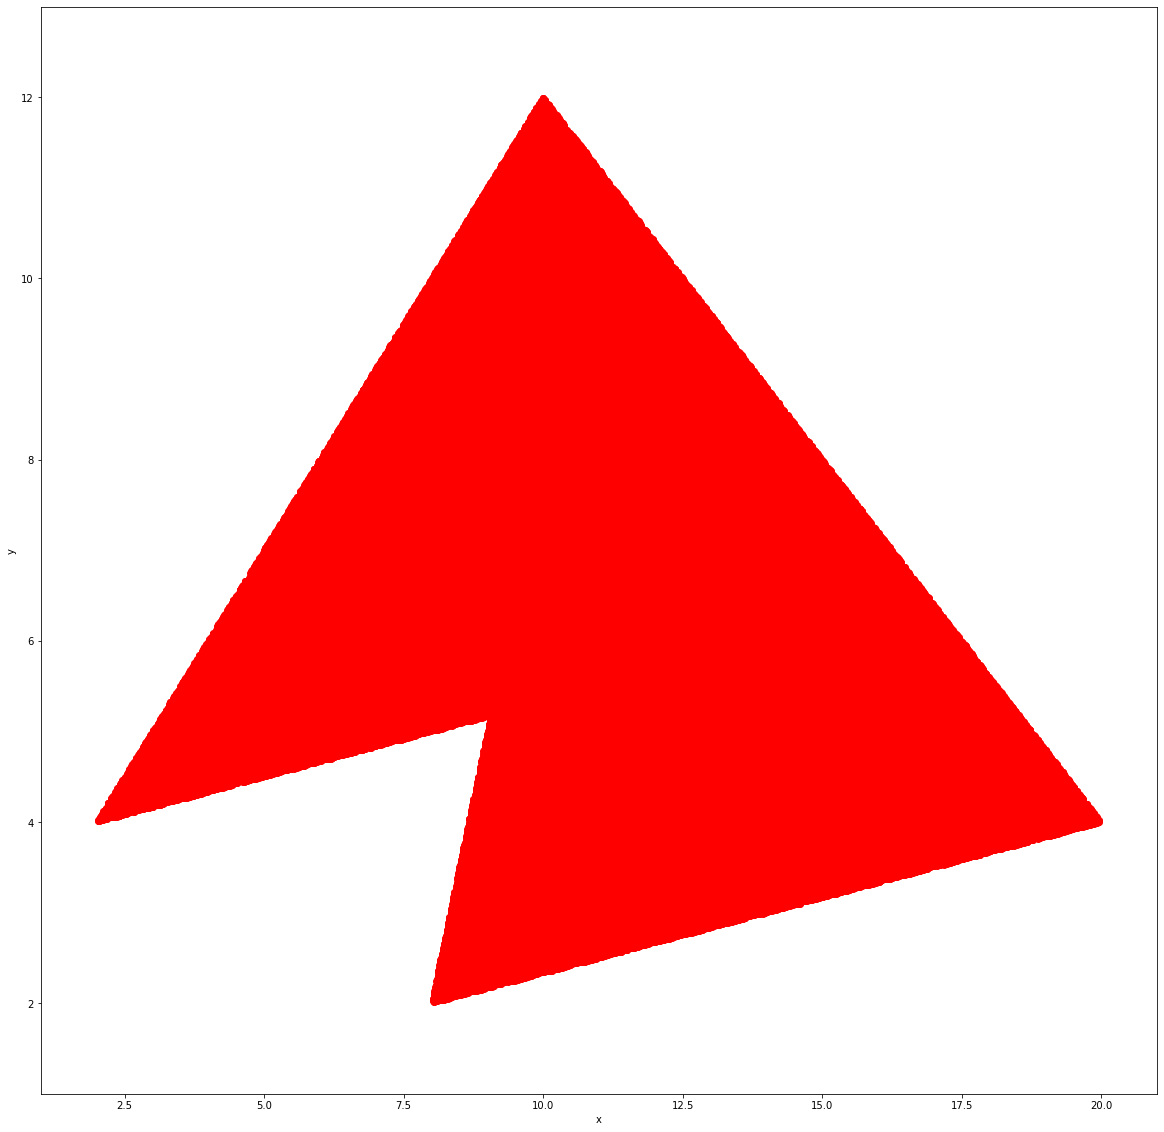

In [94]:
test_polygon5=pd.DataFrame(test_polygon4)
x=test_polygon5.iloc[:,0]
y=test_polygon5.iloc[:,1]
#print(data)
fig = plt.figure(figsize=(20, 20)) 
plt.plot(x,y,"ro")
plt.ylim(y_liminf-1,y_limsup+1)
plt.xlim(x_liminf-1,x_limsup+1)
plt.xlabel("x")
plt.ylabel("y")

In [91]:
from itertools import combinations
intersecciones=list()
combine=combinations(list(range(0,len(rectas))),r= 2)
for i in combine:
    interx=(rectas.intersepto[i[1]]-rectas.intersepto[i[0]])/(rectas.pendiente[i[0]]-rectas.pendiente[i[1]])
    intery=rectas.pendiente[i[1]]*interx+rectas.intersepto[i[1]]
    #if (rectas.punto_1[i[0]][0]<=interx<=rectas.punto_2[i[0]][0] or rectas.punto_2[i[0]][0]<=interx<=rectas.punto_1[i[0]][0]) and  (rectas.punto_1[i[1]][0]<=interx<=rectas.punto_2[i[1]][0] or rectas.punto_2[i[1]][0]<=interx<=rectas.punto_1[i[1]][0]) and (rectas.punto_1[i[0]][1]<=intery<=rectas.punto_2[i[0]][1] or rectas.punto_2[i[0]][1]<=intery<=rectas.punto_1[i[0]][1] ) and ( rectas.punto_1[i[1]][1]<=intery<=rectas.punto_2[i[1]][1] or rectas.punto_2[i[1]][1]<=intery<=rectas.punto_1[i[1]][1] )  :
        #intersecciones.append((interx.round(3),intery.round(3)))
    if (rectas.punto_1[i[0]][0]<interx<rectas.punto_2[i[0]][0] or rectas.punto_2[i[0]][0]<interx<rectas.punto_1[i[0]][0]) and  (rectas.punto_1[i[1]][0]<interx<rectas.punto_2[i[1]][0] or rectas.punto_2[i[1]][0]<interx<rectas.punto_1[i[1]][0]) and (rectas.punto_1[i[0]][1]<intery<rectas.punto_2[i[0]][1] or rectas.punto_2[i[0]][1]<intery<rectas.punto_1[i[0]][1] ) and ( rectas.punto_1[i[1]][1]<intery<rectas.punto_2[i[1]][1] or rectas.punto_2[i[1]][1]<intery<rectas.punto_1[i[1]][1] )  :
        intersecciones.append((interx.round(3),intery.round(3)))
intersecciones        

<ipython-input-91-1ec1c826ea83>:5: RuntimeWarning: divide by zero encountered in double_scalars
  interx=(rectas.intersepto[i[1]]-rectas.intersepto[i[0]])/(rectas.pendiente[i[0]]-rectas.pendiente[i[1]])


[(9.059, 5.176)]